# Prognoser med LSTM for FPL

## Table of Contents

- [Preamble](#0:-Preamble)
- [0.2: Bruker inndata](#0.2:-Bruker-inndata)
- [Målvakter](#1:-Målvakter)
- [Forsvarsspillere](#2:-Forsvarsspillere)
- [Midtbanespillere](#3:-Midtbanespillere)
- [Angrepsspillere](#4:-Angrepsspillere)
- [Eksporter prognoser](#Eksporter)

# Viktige endringer

- Gjort om data split. Den er ikke lenger tilfeldig trukket med sample. Men velges selv. Per nå er den satt til 2 første sesonger til trening, out-of-sample = pågående sesong

# Mangler: 
- [ ] Forsøker å legget til ekstra evaluerings metrics, få implementert ferdig.
- [ ] Fikse siste blokk som forsøker å bruke lstm modellen til å faktisk lage prognoser frem i tid.

# Last inn vekter
Kaggle Export: The .hdf5 weight files saved in /kaggle/working/ will appear in the "Output" section of your Kaggle notebook session after it completes. You can download them from there.
Loading Later: Remember, when you want to use these weights later (in another notebook or locally), you MUST:
Rebuild the exact same model architecture using keras_model().
Compile the model using the exact same optimizer, loss, and metrics.
Load the weights using load_model_weights_hdf5().
Load the corresponding scaling factors (mu, sigma, numF) to prepare input data and unscale predictions.

# Pakker

In [1]:
rm(list = ls(all = TRUE))

## 0: Preamble ----
library(keras)
library(tidyverse)
library(slider)
library(tensorflow)
library(glmnet)
library(httr)
library(jsonlite)

tf$constant("Hello, TensorFlow!")

# Lists to store models and scaling factors per position
model_list <- list()
scaling_factors <- list()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Loaded glmnet 4.1-8




Attaching package: ‘jsonlite’




The following object is masked from ‘package:purrr’:

    flatten




tf.Tensor(b'Hello, TensorFlow!', shape=(), dtype=string)

# Global bruker inndata

In [2]:
# Treningssplitt: in-sample <= split_gw < out-of-sample
split_gw <- 38+38

# LSTM
epoker <- 500
vindu <- 3

#Metrics for LSTM Models. Alle fungerer ikke fordi noen er for keras 3 eller heter noe annet som jeg ikke finner
metrics_regression <- c(
  metric_mean_absolute_error(),
  metric_mean_squared_error(),
  metric_root_mean_squared_error(),
  metric_mean_absolute_percentage_error(),
  metric_cosine_similarity()
)

# Til Prognosering, hvor mange uker frem ønsker du å spå fremover
antall_uker <- 7

# Til patience epoker i callback.
# Altså hvor mange epoker skal den vente før den slutter å trene modellen og gå tilbake til siste beste
num_patience <- 30

# Hent data

In [3]:
df <- read_csv("/kaggle/input/ekstra-kolonner-stigende-gw/Ekstra%20kolonner%2C%20stigende%20GW%2C%20alle%20tre%20sesonger(22-24)%2C%20heltall.csv")
alternativsammensatt <- df

Rows: 78025 Columns: 45


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): name, position, team, opponent_team
dbl  (39): xP, assists, bonus, bps, clean_sheets, creativity, expected_assis...
lgl   (1): was_home
dttm  (1): kickoff_time



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Posisjons Partisjoner

In [4]:
#----------------------------
# 0.1: Oppdeling etter posisjon
#----------------------------
gk <- alternativsammensatt |>
  filter(position == "GK")

def <- alternativsammensatt |>
  filter(position == "DEF")

mid <- alternativsammensatt |>
  filter(position == "MID")

fwd <- alternativsammensatt |>
  filter(position == "FWD")

posliste <- list(gk = gk, def = def, mid = mid, fwd = fwd)
lapply(posliste, head, n = 1);lapply(posliste, tail, n = 1)
str(gk)

unscaled_gk <- gk
unscaled_def <- def
unscaled_mid <- mid
unscaled_fwd <- fwd

name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aaron Ramsdale,GK,Arsenal,3.6,0,0,25,1,0,0,⋯,0,50,FALSE,0,1,5,8,1,0,260
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aaron Anselmino,DEF,Chelsea,1.8,0,0,0,0,0,0,⋯,0,40,FALSE,0,101,1,5,7,0,1
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aaron Ramsey,MID,Burnley,1.2,0,0,3,0,1,0.01,⋯,51,50,TRUE,0,41,6,2,6,1,367
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zack Steffen,GK,Man City,0,0,0,0,0,0,0,⋯,154,39,TRUE,0,76,1330,23,16,1,77933
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zak Sturge,DEF,Chelsea,0,0,0,0,0,0,0,⋯,16,40,TRUE,0,76,1332,3,7,1,77949
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zidane Iqbal,MID,Man United,0,0,0,0,0,0,0,⋯,119,42,TRUE,0,38,1334,10,17,1,78025
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


spc_tbl_ [8,492 × 45] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ name                      : chr [1:8492] "Aaron Ramsdale" "Aaron Ramsdale" "Aaron Ramsdale" "Aaron Ramsdale" ...
 $ position                  : chr [1:8492] "GK" "GK" "GK" "GK" ...
 $ team                      : chr [1:8492] "Arsenal" "Arsenal" "Arsenal" "Arsenal" ...
 $ xP                        : num [1:8492] 3.6 4 5.3 4.8 3.9 2 3.5 3.3 2.5 5.3 ...
 $ assists                   : num [1:8492] 0 0 0 0 0 0 0 0 0 0 ...
 $ bonus                     : num [1:8492] 0 0 0 0 0 0 0 0 0 3 ...
 $ bps                       : num [1:8492] 25 10 20 12 13 14 24 12 15 32 ...
 $ clean_sheets              : num [1:8492] 1 0 1 0 0 0 1 0 0 1 ...
 $ creativity                : num [1:8492] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_assists          : num [1:8492] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_goal_involvements: num [1:8492] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_goals            : num [1:8492] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_goals_conceded  

## 1: Målvakter

In [5]:
#----------------------------
# Define Features, Target & Scale
#----------------------------
numF <- c("assists", "creativity", "minutes", "goals_conceded", "saves",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "penalties_saved", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig")

Numeriske features: assists creativity minutes goals_conceded saves bonus bps expected_assists expected_goal_involvements expected_goals ict_index own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded penalties_saved value selected transfers_balance starts influence clean_sheets 


Kategoriske features: player_id tID oID hID 


Target variabel: total_points 


Ferdig

## 1.2

In [6]:
# Compute and store the mean and standard deviation for the target variable

mu <- mean(gk[[tar]], na.rm = TRUE)
sigma <- sd(gk[[tar]], na.rm = TRUE)

# Scale numerical features and target
gk <- gk %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)
cat("Kjørt")

Kjørt

## 1.3 GK Build Rolling Windows

In [7]:
#----------------------------
# 3. Build Rolling Windows
#----------------------------
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- gk %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(gk %>% select(row_id, GW), by = "row_id")

# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- gk %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Kjørt")

Kjørt

## 1.4 Lasso

In [8]:
# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")

#----------------------------
# 4. Lasso regression
#----------------------------

# numW as data.matrix, tar as response variable
aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu


# Build numerical rolling windows
numW <- gk %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(gk %>% select(row_id, GW), by = "row_id")

Windows with NA:  0 


Selected features:  assists minutes bonus bps expected_assists own_goals threat transfers_out expected_goals_conceded penalties_saved value selected transfers_balance clean_sheets 


## 1.5 Convert Rolling Windows

In [9]:
#============================
# 5. Convert Rolling Windows to Arrays & Extract Targets
#============================
# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

cat("Kjørt")

Kjørt

## 1.6 Data Split GK

In [10]:
#============================
# 6. Split Data into Training and Validation Sets
#============================
idx <- which(numW$GW <= split_gw)

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]

cat("Kjørt")

Kjørt

## 1.7 Model GK

In [11]:
#============================
# 7. Build the Model
#============================
# Define maximum values for categorical features
num_players   <- max(gk$player_id)
num_teams     <- max(gk$tID)
num_opponents <- max(gk$oID)
# For hID, assume it???s binary

emb_dim <- 20  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "Goalkeeper_LSTM_Model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = metrics_regression,
  run_eagerly = FALSE
)
summary(model)

Model: "Goalkeeper_LSTM_Model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_player_id (InputLa  [(None, 1)]      0        []                         
 yer)                                                                           
 input_tID (InputLayer)   [(None, 1)]       0        []                         
 input_oID (InputLayer)   [(None, 1)]       0        []                         
 input_hID (InputLayer)   [(None, 1)]       0        []                         
 embedding (Embedding)    (None, 1, 20)     26620    ['input_player_id[0][0]']  
 embedding_1 (Embedding)  (None, 1, 20)     500      ['input_tID[0][0]']        
 embedding_2 (Embedding)  (None, 1, 20)     500      ['input_oID[0][0]']        
 lambda (Lambda)          (None, 1)         0        ['input_hID[0][0]']        
 input_seq (InputLayer)   [(None, 3, 14)]   0        []                       

## FØR Fit av modellen GK

1. Legger til funksjonen callback_early_stopping().
- Patience := Hvor mange epoker skal den fortsette fra "bunn" verdien til loss funksjonen før den stopper tidlig og laster inn sist laveste observert prediksjons error.

2. Legger til Checkpoints slik at vektene til modellen kan lagres 

In [12]:
# Filepath for saving the BEST weights (unique for each position)
weights_filepath_gk <- "/kaggle/working/best_gk_weights.hdf5"
cat("Will save best GK weights to:", weights_filepath_gk, "\n")

# 1. Tidlig stopp funksjon, laster inn siste beste loss value.
# patience: how many epochs to wait after last improvement before stopping
# restore_best_weights: load the weights from the epoch with the best val_loss
early_stopping <- callback_early_stopping(
    monitor = "val_loss",
    patience = num_patience, 
    restore_best_weights = TRUE
)

# 2. Model Checkpoint Callback (to save best weights)
model_checkpoint <- callback_model_checkpoint(
    filepath = weights_filepath_gk, # Path defined above
    monitor = "val_loss",           # Monitor the same metric as early stopping
    save_best_only = TRUE,          # IMPORTANT: Only save when val_loss improves
    save_weights_only = TRUE,       # IMPORTANT: Save ONLY the weights, not the whole model
    mode = "min",                   # We want to minimize loss
    verbose = 1                     # Optional: print message when weights are saved
)

# 3. Reduce Learning Rate on Plateau Callback
reduce_lr <- callback_reduce_lr_on_plateau(
    monitor = "val_loss",  # Monitor validation loss (same as early stopping)
    factor = 0.2,          # Reduce LR to 20% of its current value (lr * factor)
    patience = 10,           # Reduce LR if val_loss doesn't improve for 5 epochs
    min_lr = 1e-6,         # Don't reduce the LR below this value
    verbose = 1            # Print a message when LR is reduced
)

scaling_factors$gk <- list(mu = mu,
                           sigma = sigma,
                           numF = numF) # numF here is the one selected by Lasso for GK
cat("GK scaling factors stored.\n")


Will save best GK weights to: /kaggle/working/best_gk_weights.hdf5 


GK scaling factors stored.


## 1.8 Trening av modell

In [13]:
#============================
# 8. Train the Model
#============================
cat("Starting GK model training...\n")
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,          
  batch_size = 64,          # Try increasing batch size (e.g., 64 or 128) for speed
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  ),
  # ADD THE CALLBACKS HERE
  callbacks = list(early_stopping, model_checkpoint, reduce_lr)
)
cat("GK model training finished.\n")

Starting GK model training...


GK model training finished.


## Lagre Modellvekter

In [14]:
#============================
# 9. Generate Predictions & Invert Scaling on Validation Set
#============================
# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_gk <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )


preds_gk <- preds_gk %>%
  left_join(unscaled_gk, by = "row_id") # Use unscaled_gk

# View the predictions table
glimpse(preds_gk)

Rows: 2,228
Columns: 49
$ row_id                        <dbl> 336, 337, 338, 339, 340, 341, 342, 343, …
$ predicted_total_points_scaled <dbl> 0.6662503, 0.4616901, 0.5438441, 0.51677…
$ actual_total_points_scaled    <dbl> -0.42194588, -0.42194588, 0.55840006, 1.…
$ predicted_total_points        <dbl> 2.220025, 1.802702, 1.970304, 1.915074, …
$ actual_total_points           <dbl> 0, 0, 2, 3, 3, 2, 2, 1, 4, 9, 0, 0, 0, 0…
$ name                          <chr> "Aaron Ramsdale", "Aaron Ramsdale", "Aar…
$ position                      <chr> "GK", "GK", "GK", "GK", "GK", "GK", "GK"…
$ team                          <chr> "Arsenal", "Arsenal", "Southampton", "So…
$ xP                            <dbl> 3.2, 1.0, 0.2, 0.7, 2.0, 2.2, 1.0, 1.2, …
$ assists                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bonus                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0…
$ bps                           <dbl> 0, 0, 5, 12, 15, 5, 5, -2, 24, 33, 5, 0,…
$ clean_sheets  

## 1.10 Plots Evaluation Data

Rows: 6,500
Columns: 4
$ epoch  <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …
$ value  <dbl> 0.9703714, 0.7201726, 0.6533843, 0.6392603, 0.6280434, 0.623896…
$ metric <fct> loss, loss, loss, loss, loss, loss, loss, loss, loss, loss, los…
$ data   <fct> training, training, training, training, training, training, tra…


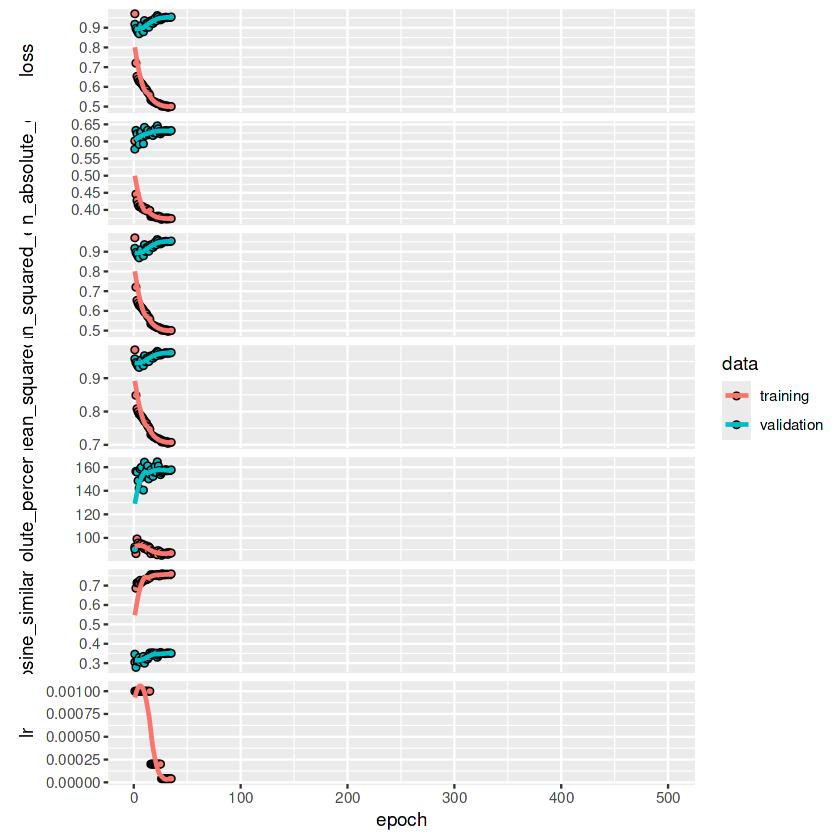

In [15]:
plot(history)

history_df_gk <- data.frame(history)

glimpse(history_df_gk)

## 1.11 Lagre modell og prediksjoner

In [16]:
# Store GK model and scaling factors
model_list$gk <- model
cat("GK model stored in Notebook Memory.\n")

# Clean up validation predictions (select essential columns)
preds_gk_clean <- preds_gk %>%
  select(row_id, GW, player_id, name, position, team, # Identifiers from unscaled_gk join
         actual_total_points, predicted_total_points, value)

GK model stored in Notebook Memory.


### 1.10.1 More Post Evaluation

In [17]:
# After training, evaluate the model on validation data with all metrics
model_evaluation <- model %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val,
  verbose = 1
)

# Print the evaluation results (metrics specified during compilation)
print(model_evaluation)

# Combine results by position
validation_metrics <- list()
validation_metrics$gk <- model_list$gk %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val
)

                          loss            mean_absolute_error 
                     0.8690171                      0.5915390 
            mean_squared_error        root_mean_squared_error 
                     0.8690171                      0.9322109 
mean_absolute_percentage_error              cosine_similarity 
                   141.9394531                      0.3294435 


## 2: Forsvarsspillere

In [18]:
#----------------------------
# Define Features, Target & Scale
#----------------------------
numF <- c("assists", "creativity", "minutes", "goals_conceded",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig")

Numeriske features: assists creativity minutes goals_conceded bonus bps expected_assists expected_goal_involvements expected_goals ict_index own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded value selected transfers_balance starts influence clean_sheets 


Kategoriske features: player_id tID oID hID 


Target variabel: total_points 


Ferdig

In [19]:
# Compute and store the mean and standard deviation for the target variable

mu <- mean(def[[tar]], na.rm = TRUE)
sigma <- sd(def[[tar]], na.rm = TRUE)

# Scale numerical features and target
def <- def %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)

cat("Kjørt")

Kjørt

In [20]:
### 2.3 DEF Building rolling windows

In [21]:
#----------------------------
# 3. Build Rolling Windows
#----------------------------
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- def %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1, # prevents the model from seeing current gw data
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(def %>% select(row_id, GW), by = "row_id")
# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- def %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Kjørt")

Kjørt

In [22]:
# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")

#----------------------------
# 4. Lasso regression
#----------------------------
# numW as data.matrix, tar as response variable

aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- def %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(def %>% select(row_id, GW), by = "row_id")

cat("Kjørt")

Windows with NA:  0 


Selected features:  creativity minutes bonus bps expected_goal_involvements red_cards threat transfers_in expected_goals_conceded value selected transfers_balance 


Kjørt

In [23]:
#============================
# 5. Convert Rolling Windows to Arrays & Extract Targets
#============================
# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

## 6.Data split DEF

In [24]:

#============================
# 6. Split Data into Training and Validation Sets
#============================
idx <- which(numW$GW <= split_gw)

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]

## 2.7 Model

In [25]:

#============================
# 7. Build the Model
#============================
# Define maximum values for categorical features
num_players   <- max(mid$player_id)
num_teams     <- max(mid$tID)
num_opponents <- max(mid$oID)
# For hID, assume it???s binary

emb_dim <- 20  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "def_lstm_model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = metrics_regression,
  run_eagerly = TRUE
)
summary(model)

Model: "def_lstm_model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_player_id (InputLa  [(None, 1)]      0        []                         
 yer)                                                                           
 input_tID (InputLayer)   [(None, 1)]       0        []                         
 input_oID (InputLayer)   [(None, 1)]       0        []                         
 input_hID (InputLayer)   [(None, 1)]       0        []                         
 embedding_3 (Embedding)  (None, 1, 20)     26700    ['input_player_id[0][0]']  
 embedding_4 (Embedding)  (None, 1, 20)     500      ['input_tID[0][0]']        
 embedding_5 (Embedding)  (None, 1, 20)     500      ['input_oID[0][0]']        
 lambda_1 (Lambda)        (None, 1)         0        ['input_hID[0][0]']        
 input_seq (InputLayer)   [(None, 3, 12)]   0        []                         
 fla

## Før fit av modellen DEF

In [26]:
# Filepath for saving the BEST weights (unique for each position)
weights_filepath_def <- "/kaggle/working/best_def_weights.hdf5"
cat("Will save best DEF weights to:", weights_filepath_def, "\n")

# 1. Early Stopping Callback
early_stopping <- callback_early_stopping(
    monitor = "val_loss",       # Monitor validation loss
    patience = num_patience,              # Stop after 10 epochs of no improvement
    restore_best_weights = TRUE # Optional but good: restores weights from the best epoch at the end of training
                                # Note: Checkpoint callback is the primary saver here.
)

# 2. Model Checkpoint Callback (to save best weights)
model_checkpoint <- callback_model_checkpoint(
    filepath = weights_filepath_def, # Path defined above
    monitor = "val_loss",           # Monitor the same metric as early stopping
    save_best_only = TRUE,          # IMPORTANT: Only save when val_loss improves
    save_weights_only = TRUE,       # IMPORTANT: Save ONLY the weights, not the whole model
    mode = "min",                   # We want to minimize loss
    verbose = 1                     # Optional: print message when weights are saved
)

reduce_lr <- callback_reduce_lr_on_plateau(
    monitor = "val_loss",  # Monitor validation loss (same as early stopping)
    factor = 0.2,          # Reduce LR to 20% of its current value (lr * factor)
    patience = 5,           # Reduce LR if val_loss doesn't improve for 5 epochs
    min_lr = 1e-6,         # Don't reduce the LR below this value
    verbose = 1            # Print a message when LR is reduced
)

# Store scaling factors NOW (before potential errors during training)
# Ensure mu, sigma, and numF (Lasso selected) are correctly captured from the GK scaling steps
scaling_factors$def <- list(
    mu = mu,         # Mean of GK target used for scaling
    sigma = sigma,   # SD of GK target used for scaling
    numF = numF      # Vector of Lasso-selected numerical feature names for GK
)
cat("DEF scaling factors stored.\n")

Will save best DEF weights to: /kaggle/working/best_def_weights.hdf5 


DEF scaling factors stored.


In [27]:
#============================
# 8. Train the Model
#============================
cat("Starting DEF model training...\n")
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,          # Max epochs
  batch_size = 64,          # Try increasing batch size (e.g., 64 or 128) for speed
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  ),
  # ADD THE CALLBACKS HERE
  callbacks = list(early_stopping, model_checkpoint, reduce_lr)
)
cat("DEF model training finished.\n")

Starting DEF model training...


DEF model training finished.


In [28]:

#============================
# 9. Generate Predictions & Invert Scaling on Validation Set
#============================
# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_def <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )

preds_def <- preds_def %>%
  left_join(unscaled_def, by = "row_id") # Use unscaled_def

# View the predictions table
glimpse(preds_def)

Rows: 7,026
Columns: 49
$ row_id                        <dbl> 4, 5, 6, 7, 122, 123, 124, 125, 126, 127…
$ predicted_total_points_scaled <dbl> 0.2639800608, -0.2623673379, -0.01195584…
$ actual_total_points_scaled    <dbl> -0.46568846, -0.46568846, -0.46568846, -…
$ predicted_total_points        <dbl> 1.6034214, 0.4467912, 0.9970618, 0.97575…
$ actual_total_points           <dbl> 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0…
$ name                          <chr> "Aaron Anselmino", "Aaron Anselmino", "A…
$ position                      <chr> "DEF", "DEF", "DEF", "DEF", "DEF", "DEF"…
$ team                          <chr> "Chelsea", "Chelsea", "Chelsea", "Chelse…
$ xP                            <dbl> 0.5, 0.0, 0.5, 0.5, 1.0, 0.5, -0.2, 0.1,…
$ assists                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bonus                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bps                           <dbl> 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 2, 0, 1, 0…
$ clean_sheets  

## DEF Eval plots

Rows: 6,500
Columns: 4
$ epoch  <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …
$ value  <dbl> 0.9266058, 0.8265300, 0.8138037, 0.8057609, 0.7960756, 0.787922…
$ metric <fct> loss, loss, loss, loss, loss, loss, loss, loss, loss, loss, los…
$ data   <fct> training, training, training, training, training, training, tra…


DEF model and scaling factors stored.


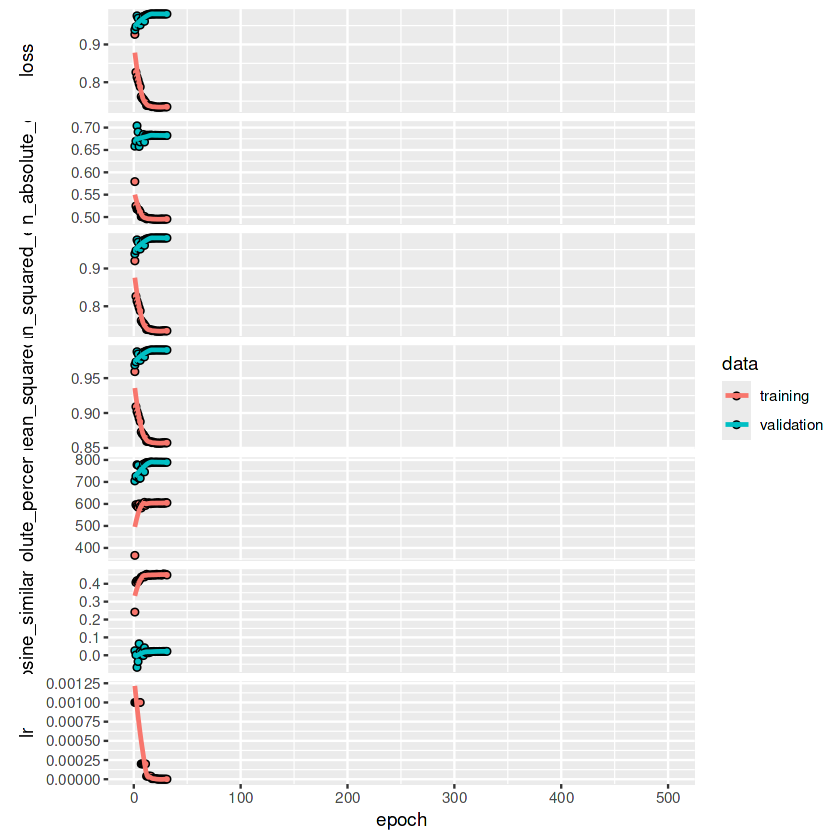

In [29]:
plot(history)

history_df_def <- as.data.frame(history)

glimpse(history_df_def)


# Store DEF model and scaling factors
model_list$def <- model
cat("DEF model and scaling factors stored.\n")

# Clean up validation predictions (select essential columns)
# Note: The join in cell d3115b67 uses 'def' (scaled) then 'unscaled_def'.
# We need identifiers from unscaled_def.
preds_def_clean <- preds_def %>%
  select(row_id, GW, player_id, name, position, team, # Identifiers from unscaled_def join
         actual_total_points, predicted_total_points, value)

### Eval DEF

In [30]:
# After training, evaluate the model on validation data with all metrics
model_evaluation <- model %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val,
  verbose = 1
)

# Print the evaluation results (metrics specified during compilation)
print(model_evaluation)

# Combine results by position
validation_metrics$def <- model_list$def %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val
)

                          loss            mean_absolute_error 
                    0.93867135                     0.65842080 
            mean_squared_error        root_mean_squared_error 
                    0.93867135                     0.96885055 
mean_absolute_percentage_error              cosine_similarity 
                  704.60119629                     0.02561913 


## 3: Midtbanespillere

In [31]:
#----------------------------
# Define Features, Target & Scale
#----------------------------
numF <- c("assists", "creativity", "minutes", "goals_conceded",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig")

Numeriske features: assists creativity minutes goals_conceded bonus bps expected_assists expected_goal_involvements expected_goals ict_index own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded value selected transfers_balance starts influence clean_sheets 


Kategoriske features: player_id tID oID hID 


Target variabel: total_points 


Ferdig

In [32]:
# Compute and store the mean and standard deviation for the target variable

mu <- mean(mid[[tar]], na.rm = TRUE)
sigma <- sd(mid[[tar]], na.rm = TRUE)

# Scale numerical features and target
mid <- mid %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)
cat("Kjørt")

Kjørt

### 3.3 MID Building Rolling Windows

In [33]:
#----------------------------
# 3. Build Rolling Windows
#----------------------------
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- mid %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1, # prevents the model from seeing current gw data
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(mid %>% select(row_id, GW), by = "row_id")
# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- mid %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Kjørt")

Kjørt

In [34]:
# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")

#----------------------------
# 4. Lasso regression
#----------------------------
# numW as data.matrix, tar as response variable

aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- mid %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(mid %>% select(row_id, GW), by = "row_id")

Windows with NA:  0 


Selected features:  assists creativity minutes goals_conceded bonus bps expected_assists expected_goal_involvements expected_goals own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded value selected starts influence clean_sheets 


In [35]:
#============================
# 5. Convert Rolling Windows to Arrays & Extract Targets
#============================
# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

## 6. Data split MID

In [36]:
#============================
# 6. Split Data into Training and Validation Sets
#============================
idx <- which(numW$GW <= split_gw)

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]

In [37]:
#============================
# 7. Build the Model
#============================
# Define maximum values for categorical features
num_players   <- max(mid$player_id)
num_teams     <- max(mid$tID)
num_opponents <- max(mid$oID)
# For hID, assume it???s binary

emb_dim <- 20  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "mid_lstm_model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = metrics_regression,
  run_eagerly = TRUE
)
summary(model)

Model: "mid_lstm_model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_player_id (InputLa  [(None, 1)]      0        []                         
 yer)                                                                           
 input_tID (InputLayer)   [(None, 1)]       0        []                         
 input_oID (InputLayer)   [(None, 1)]       0        []                         
 input_hID (InputLayer)   [(None, 1)]       0        []                         
 embedding_6 (Embedding)  (None, 1, 20)     26700    ['input_player_id[0][0]']  
 embedding_7 (Embedding)  (None, 1, 20)     500      ['input_tID[0][0]']        
 embedding_8 (Embedding)  (None, 1, 20)     500      ['input_oID[0][0]']        
 lambda_2 (Lambda)        (None, 1)         0        ['input_hID[0][0]']        
 input_seq (InputLayer)   [(None, 3, 21)]   0        []                         
 fla

## Før fit av modellen MID

In [38]:
# Filepath for saving the BEST weights (unique for each position)
weights_filepath_mid <- "/kaggle/working/best_mid_weights.hdf5"
cat("Will save best MID weights to:", weights_filepath_mid, "\n")

# 1. Early Stopping Callback
early_stopping <- callback_early_stopping(
    monitor = "val_loss",       # Monitor validation loss
    patience = num_patience,              # Stop after 10 epochs of no improvement
    restore_best_weights = TRUE # Optional but good: restores weights from the best epoch at the end of training
                                # Note: Checkpoint callback is the primary saver here.
)

# 2. Model Checkpoint Callback (to save best weights)
model_checkpoint <- callback_model_checkpoint(
    filepath = weights_filepath_mid, # Path defined above
    monitor = "val_loss",           # Monitor the same metric as early stopping
    save_best_only = TRUE,          # IMPORTANT: Only save when val_loss improves
    save_weights_only = TRUE,       # IMPORTANT: Save ONLY the weights, not the whole model
    mode = "min",                   # We want to minimize loss
    verbose = 1                     # Optional: print message when weights are saved
)

reduce_lr <- callback_reduce_lr_on_plateau(
    monitor = "val_loss",  # Monitor validation loss (same as early stopping)
    factor = 0.2,          # Reduce LR to 20% of its current value (lr * factor)
    patience = 5,           # Reduce LR if val_loss doesn't improve for 5 epochs
    min_lr = 1e-6,         # Don't reduce the LR below this value
    verbose = 1            # Print a message when LR is reduced
)

# Store scaling factors NOW (before potential errors during training)
# Ensure mu, sigma, and numF (Lasso selected) are correctly captured from the GK scaling steps
scaling_factors$mid <- list(
    mu = mu,         # Mean of GK target used for scaling
    sigma = sigma,   # SD of GK target used for scaling
    numF = numF      # Vector of Lasso-selected numerical feature names for GK
)
cat("MID scaling factors stored.\n")

Will save best MID weights to: /kaggle/working/best_mid_weights.hdf5 


MID scaling factors stored.


In [39]:
#============================
# 8. Train the Model
#============================
cat("Starting MID model training...\n")
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,          # Max epochs
  batch_size = 64,          # Try increasing batch size (e.g., 64 or 128) for speed
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  ),
  # ADD THE CALLBACKS HERE
  callbacks = list(early_stopping, model_checkpoint, reduce_lr)
)
cat("MID model training finished.\n")

Starting MID model training...


MID model training finished.


In [40]:

#============================
# 9. Generate Predictions & Invert Scaling on Validation Set
#============================
# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_mid <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )

preds_mid <- preds_mid %>%
  left_join(unscaled_mid, by = "row_id") # Use unscaled_mid

# View the predictions table
glimpse(preds_mid)

Rows: 9,502
Columns: 49
$ row_id                        <dbl> 587, 588, 589, 590, 591, 592, 593, 594, …
$ predicted_total_points_scaled <dbl> 0.06482147, 0.01102212, 0.46640980, -0.0…
$ actual_total_points_scaled    <dbl> 0.32314972, -0.09825256, -0.09825256, -0…
$ predicted_total_points        <dbl> 1.386979, 1.259312, 2.339960, 1.157959, …
$ actual_total_points           <dbl> 2, 1, 1, 0, 2, 2, 3, 3, 2, 0, 3, 3, 2, 3…
$ name                          <chr> "Abdoulaye Doucoure", "Abdoulaye Doucour…
$ position                      <chr> "MID", "MID", "MID", "MID", "MID", "MID"…
$ team                          <chr> "Everton", "Everton", "Everton", "Everto…
$ xP                            <dbl> 2.0, 1.5, 1.3, 1.0, 1.5, 1.3, 1.3, 2.7, …
$ assists                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bonus                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bps                           <dbl> 2, 3, 4, 0, 14, 7, 11, 11, 13, 0, 16, 7,…
$ clean_sheets  

## Eval plots mid

Rows: 6,500
Columns: 4
$ epoch  <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …
$ value  <dbl> 0.8591099, 0.7210456, 0.7064748, 0.6982055, 0.6894090, 0.682071…
$ metric <fct> loss, loss, loss, loss, loss, loss, loss, loss, loss, loss, los…
$ data   <fct> training, training, training, training, training, training, tra…


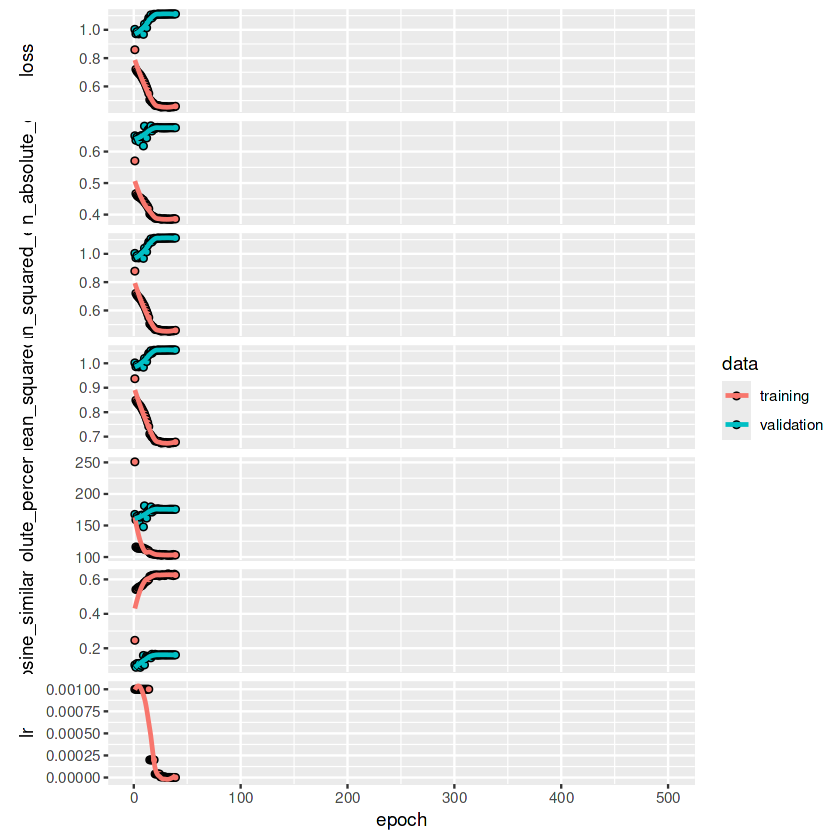

In [41]:
plot(history)

history_df_mid <- as.data.frame(history)

glimpse(history_df_mid)

## 3.11 Lagre modell og prediksjoner

In [42]:
# Store MID model and scaling factors
model_list$mid <- model
scaling_factors$mid <- list(mu = mu, sigma = sigma, numF = numF) # numF here is the one selected by Lasso for MID
cat("MID model and scaling factors stored.\n")

# Clean up validation predictions (select essential columns)
# Note: The join in cell a38dc192 uses 'mid' (scaled) then 'unscaled_mid'.
preds_mid_clean <- preds_mid %>%
   select(row_id, GW, player_id, name, position, team, # Identifiers from unscaled_mid join
         actual_total_points, predicted_total_points, value)

#save_model_tf(model, filepath = "/kaggle/working/midmodel_tf")

MID model and scaling factors stored.


In [43]:
# After training, evaluate the model on validation data with all metrics
model_evaluation <- model %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val,
  verbose = 1
)

# Print the evaluation results (metrics specified during compilation)
print(model_evaluation)

# Combine results by position
validation_metrics$mid <- model_list$mid %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val
)

                          loss            mean_absolute_error 
                     0.9678438                      0.6177761 
            mean_squared_error        root_mean_squared_error 
                     0.9678438                      0.9837905 
mean_absolute_percentage_error              cosine_similarity 
                   147.8038788                      0.1582825 


## 4: Angrepsspillere

In [44]:
#----------------------------
# Define Features, Target & Scale
#----------------------------
numF <- c("assists", "creativity", "minutes", "goals_conceded",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig")

Numeriske features: assists creativity minutes goals_conceded bonus bps expected_assists expected_goal_involvements expected_goals ict_index own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded value selected transfers_balance starts influence clean_sheets 


Kategoriske features: player_id tID oID hID 


Target variabel: total_points 


Ferdig

In [45]:
# numF, catF og tar variablene brukes på nytt
# Compute and store the mean and standard deviation for the target variable
mu <- mean(fwd[[tar]], na.rm = TRUE)
sigma <- sd(fwd[[tar]], na.rm = TRUE)

# Scale numerical features and target
fwd <- fwd %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)
cat("Kjørt")

Kjørt

### FWD Building rolling windows

In [46]:
#----------------------------
# 3. Build Rolling Windows
#----------------------------
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- fwd %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1, # prevents the model from seeing current gw data
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(fwd %>% select(row_id, GW), by = "row_id")
# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- fwd %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Kjørt")

Kjørt

In [47]:
# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")

#----------------------------
# 4. Lasso regression
#----------------------------
# numW as data.matrix, tar as response variable

aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- fwd %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()

numW <- numW %>%
  left_join(fwd %>% select(row_id, GW), by = "row_id")

Windows with NA:  0 


Selected features:  assists creativity minutes bps own_goals red_cards transfers_in transfers_out yellow_cards value selected 


In [48]:
#============================
# 5. Convert Rolling Windows to Arrays & Extract Targets
#============================
# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

## 6. Data split FWD

In [49]:
#============================
# 6. Split Data into Training and Validation Sets
#============================
idx <- which(numW$GW <= split_gw)

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]

In [50]:
#============================
# 7. Build the Model
#============================
# Define maximum values for categorical features
num_players   <- max(fwd$player_id)
num_teams     <- max(fwd$tID)
num_opponents <- max(fwd$oID)
# For hID, assume it???s binary

emb_dim <- 20  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = emb_dim, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "fwd_lstm_model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = metrics_regression,
  run_eagerly = TRUE
)
summary(model)

Model: "fwd_lstm_model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_player_id (InputLa  [(None, 1)]      0        []                         
 yer)                                                                           
 input_tID (InputLayer)   [(None, 1)]       0        []                         
 input_oID (InputLayer)   [(None, 1)]       0        []                         
 input_hID (InputLayer)   [(None, 1)]       0        []                         
 embedding_9 (Embedding)  (None, 1, 20)     26680    ['input_player_id[0][0]']  
 embedding_10 (Embedding)  (None, 1, 20)    500      ['input_tID[0][0]']        
 embedding_11 (Embedding)  (None, 1, 20)    500      ['input_oID[0][0]']        
 lambda_3 (Lambda)        (None, 1)         0        ['input_hID[0][0]']        
 input_seq (InputLayer)   [(None, 3, 11)]   0        []                         
 fla

## Før fit av modellen FWD

In [51]:
# Filepath for saving the BEST weights (unique for each position)
weights_filepath_fwd <- "/kaggle/working/best_fwd_weights.hdf5"
cat("Will save best FWD weights to:", weights_filepath_fwd, "\n")

# 1. Early Stopping Callback
early_stopping <- callback_early_stopping(
    monitor = "val_loss",       # Monitor validation loss
    patience = num_patience,              # Stop after 10 epochs of no improvement
    restore_best_weights = TRUE # Optional but good: restores weights from the best epoch at the end of training
                                # Note: Checkpoint callback is the primary saver here.
)

# 2. Model Checkpoint Callback (to save best weights)
model_checkpoint <- callback_model_checkpoint(
    filepath = weights_filepath_fwd, # Path defined above
    monitor = "val_loss",           # Monitor the same metric as early stopping
    save_best_only = TRUE,          # IMPORTANT: Only save when val_loss improves
    save_weights_only = TRUE,       # IMPORTANT: Save ONLY the weights, not the whole model
    mode = "min",                   # We want to minimize loss
    verbose = 1                     # Optional: print message when weights are saved
)

reduce_lr <- callback_reduce_lr_on_plateau(
    monitor = "val_loss",  # Monitor validation loss (same as early stopping)
    factor = 0.2,          # Reduce LR to 20% of its current value (lr * factor)
    patience = 5,           # Reduce LR if val_loss doesn't improve for 5 epochs
    min_lr = 1e-6,         # Don't reduce the LR below this value
    verbose = 1            # Print a message when LR is reduced
)

# Store scaling factors NOW (before potential errors during training)
# Ensure mu, sigma, and numF (Lasso selected) are correctly captured from the FWD scaling steps
scaling_factors$fwd <- list(
    mu = mu,         # Mean of FWD target used for scaling
    sigma = sigma,   # SD of FWD target used for scaling
    numF = numF      # Vector of Lasso-selected numerical feature names for FWD
)
cat("FWD scaling factors stored.\n")

Will save best FWD weights to: /kaggle/working/best_fwd_weights.hdf5 


FWD scaling factors stored.


In [52]:
#============================
# 8. Train the Model
#============================
cat("Starting FWD model training...\n")
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,          # Max epochs
  batch_size = 64,          # Try increasing batch size (e.g., 64 or 128) for speed
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  ),
  # ADD THE CALLBACKS HERE
  callbacks = list(early_stopping, model_checkpoint, reduce_lr)
)
cat("FWD model training finished.\n")

Starting FWD model training...


FWD model training finished.


In [53]:
#============================
# 9. Generate Predictions & Invert Scaling on Validation Set
#============================
# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_fwd <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )

preds_fwd <- preds_fwd %>%
  left_join(unscaled_fwd, by = "row_id") # Use unscaled_mid

glimpse(preds_fwd)

Rows: 2,342
Columns: 49
$ row_id                        <dbl> 734, 735, 736, 737, 738, 739, 740, 741, …
$ predicted_total_points_scaled <dbl> -0.053984080, -0.074054226, -0.144909233…
$ actual_total_points_scaled    <dbl> 0.2527281, -0.1202728, -0.1202728, -0.49…
$ predicted_total_points        <dbl> 1.1777173, 1.1239100, 0.9339506, 0.99380…
$ actual_total_points           <dbl> 2, 1, 1, 0, 1, 0, 1, 0, 0, 7, 2, 7, 5, 1…
$ name                          <chr> "Adam Armstrong", "Adam Armstrong", "Ada…
$ position                      <chr> "FWD", "FWD", "FWD", "FWD", "FWD", "FWD"…
$ team                          <chr> "Southampton", "Southampton", "Southampt…
$ xP                            <dbl> 0.7, 1.0, 0.8, 0.5, 0.8, -0.2, -1.0, -0.…
$ assists                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0…
$ bonus                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0…
$ bps                           <dbl> 5, 1, 0, 0, 3, 0, 2, 0, -1, 32, 1, 33, 1…
$ clean_sheets  

## Eval Plots FWD

Rows: 6,500
Columns: 4
$ epoch  <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …
$ value  <dbl> 0.9315603, 0.7521467, 0.7186605, 0.7075807, 0.6968675, 0.691645…
$ metric <fct> loss, loss, loss, loss, loss, loss, loss, loss, loss, loss, los…
$ data   <fct> training, training, training, training, training, training, tra…


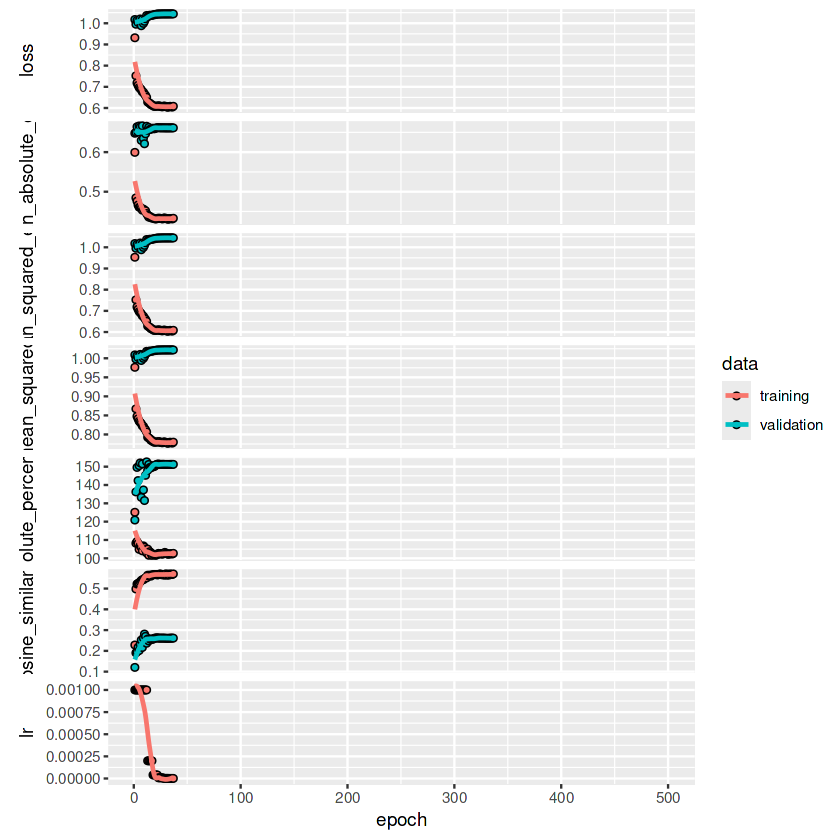

In [54]:
plot(history)

history_df_fwd <- data.frame(history)

glimpse(history_df_fwd)

## Lagre modell og prediksjoner

In [55]:
# Store FWD model and scaling factors
model_list$fwd <- model
cat("FWD model and scaling factors stored.\n")

# Clean up validation predictions (select essential columns)
# Note: The join in cell f2292df7 uses 'fwd' (scaled) then 'unscaled_fwd'.
preds_fwd_clean <- preds_fwd %>%
   select(row_id, GW , player_id , name, position, team, # Identifiers from unscaled_fwd join
         actual_total_points, predicted_total_points, value)

FWD model and scaling factors stored.


### Evaluate Angrep

In [56]:
# After training, evaluate the model on validation data with all metrics
model_evaluation <- model %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val,
  verbose = 1
)

# Print the evaluation results (metrics specified during compilation)
print(model_evaluation)

# Combine results by position
validation_metrics$fwd <- model_list$fwd %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val
)

                          loss            mean_absolute_error 
                     0.9883209                      0.6295782 
            mean_squared_error        root_mean_squared_error 
                     0.9883209                      0.9941433 
mean_absolute_percentage_error              cosine_similarity 
                   133.2515869                      0.2519214 


## Sett sammen tibbler

In [57]:
glimpse(preds_gk)
glimpse(preds_def)
glimpse(preds_mid)
glimpse(preds_fwd)

# filepath: c:\Users\peram\Documents\test\R Forecast\prognose-modell.ipynb
# Combine the CLEANED validation predictions
validation_results_df <- bind_rows(
    preds_gk_clean,
    preds_def_clean,
    preds_mid_clean,
    preds_fwd_clean
  ) %>%
  arrange(player_id, GW)

glimpse(validation_results_df)

# Keep the original detailed forecast df as well (optional)
forecastdf_detailed <- bind_rows(preds_gk, preds_def, preds_mid, preds_fwd)
cat("Clean and detailed validation results combined.\n")

Rows: 2,228
Columns: 49
$ row_id                        <dbl> 336, 337, 338, 339, 340, 341, 342, 343, …
$ predicted_total_points_scaled <dbl> 0.6662503, 0.4616901, 0.5438441, 0.51677…
$ actual_total_points_scaled    <dbl> -0.42194588, -0.42194588, 0.55840006, 1.…
$ predicted_total_points        <dbl> 2.220025, 1.802702, 1.970304, 1.915074, …
$ actual_total_points           <dbl> 0, 0, 2, 3, 3, 2, 2, 1, 4, 9, 0, 0, 0, 0…
$ name                          <chr> "Aaron Ramsdale", "Aaron Ramsdale", "Aar…
$ position                      <chr> "GK", "GK", "GK", "GK", "GK", "GK", "GK"…
$ team                          <chr> "Arsenal", "Arsenal", "Southampton", "So…
$ xP                            <dbl> 3.2, 1.0, 0.2, 0.7, 2.0, 2.2, 1.0, 1.2, …
$ assists                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bonus                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0…
$ bps                           <dbl> 0, 0, 5, 12, 15, 5, 5, -2, 24, 33, 5, 0,…
$ clean_sheets  

Rows: 7,026
Columns: 49
$ row_id                        <dbl> 4, 5, 6, 7, 122, 123, 124, 125, 126, 127…
$ predicted_total_points_scaled <dbl> 0.2639800608, -0.2623673379, -0.01195584…
$ actual_total_points_scaled    <dbl> -0.46568846, -0.46568846, -0.46568846, -…
$ predicted_total_points        <dbl> 1.6034214, 0.4467912, 0.9970618, 0.97575…
$ actual_total_points           <dbl> 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0…
$ name                          <chr> "Aaron Anselmino", "Aaron Anselmino", "A…
$ position                      <chr> "DEF", "DEF", "DEF", "DEF", "DEF", "DEF"…
$ team                          <chr> "Chelsea", "Chelsea", "Chelsea", "Chelse…
$ xP                            <dbl> 0.5, 0.0, 0.5, 0.5, 1.0, 0.5, -0.2, 0.1,…
$ assists                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bonus                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bps                           <dbl> 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 2, 0, 1, 0…
$ clean_sheets  

Rows: 9,502
Columns: 49
$ row_id                        <dbl> 587, 588, 589, 590, 591, 592, 593, 594, …
$ predicted_total_points_scaled <dbl> 0.06482147, 0.01102212, 0.46640980, -0.0…
$ actual_total_points_scaled    <dbl> 0.32314972, -0.09825256, -0.09825256, -0…
$ predicted_total_points        <dbl> 1.386979, 1.259312, 2.339960, 1.157959, …
$ actual_total_points           <dbl> 2, 1, 1, 0, 2, 2, 3, 3, 2, 0, 3, 3, 2, 3…
$ name                          <chr> "Abdoulaye Doucoure", "Abdoulaye Doucour…
$ position                      <chr> "MID", "MID", "MID", "MID", "MID", "MID"…
$ team                          <chr> "Everton", "Everton", "Everton", "Everto…
$ xP                            <dbl> 2.0, 1.5, 1.3, 1.0, 1.5, 1.3, 1.3, 2.7, …
$ assists                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bonus                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bps                           <dbl> 2, 3, 4, 0, 14, 7, 11, 11, 13, 0, 16, 7,…
$ clean_sheets  

Rows: 2,342
Columns: 49
$ row_id                        <dbl> 734, 735, 736, 737, 738, 739, 740, 741, …
$ predicted_total_points_scaled <dbl> -0.053984080, -0.074054226, -0.144909233…
$ actual_total_points_scaled    <dbl> 0.2527281, -0.1202728, -0.1202728, -0.49…
$ predicted_total_points        <dbl> 1.1777173, 1.1239100, 0.9339506, 0.99380…
$ actual_total_points           <dbl> 2, 1, 1, 0, 1, 0, 1, 0, 0, 7, 2, 7, 5, 1…
$ name                          <chr> "Adam Armstrong", "Adam Armstrong", "Ada…
$ position                      <chr> "FWD", "FWD", "FWD", "FWD", "FWD", "FWD"…
$ team                          <chr> "Southampton", "Southampton", "Southampt…
$ xP                            <dbl> 0.7, 1.0, 0.8, 0.5, 0.8, -0.2, -1.0, -0.…
$ assists                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0…
$ bonus                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0…
$ bps                           <dbl> 5, 1, 0, 0, 3, 0, 2, 0, -1, 32, 1, 33, 1…
$ clean_sheets  

Rows: 21,098
Columns: 9
$ row_id                 <dbl> 4, 5, 6, 7, 122, 123, 124, 125, 126, 127, 128, …
$ GW                     <dbl> 104, 105, 106, 107, 77, 78, 79, 80, 81, 82, 83,…
$ player_id              <dbl> 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ name                   <chr> "Aaron Anselmino", "Aaron Anselmino", "Aaron An…
$ position               <chr> "DEF", "DEF", "DEF", "DEF", "DEF", "DEF", "DEF"…
$ team                   <chr> "Chelsea", "Chelsea", "Chelsea", "Chelsea", "We…
$ actual_total_points    <dbl> 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,…
$ predicted_total_points <dbl> 1.6034214, 0.4467912, 0.9970618, 0.9757550, 1.0…
$ value                  <dbl> 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,…


Clean and detailed validation results combined.


### Evaluation Tibbler

In [58]:
# Create metrics comparison dataframe
metrics_df <- data.frame(
  metric = names(validation_metrics$gk),
  GK = unlist(validation_metrics$gk),
  DEF = unlist(validation_metrics$def),
  MID = unlist(validation_metrics$mid),
  FWD = unlist(validation_metrics$fwd)
)

metrics_df

,metric,GK,DEF,MID,FWD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
loss,loss,0.8690171,0.93867135,0.9678438,0.9883209
mean_absolute_error,mean_absolute_error,0.5915390,0.65842080,0.6177761,0.6295782
mean_squared_error,mean_squared_error,0.8690171,0.93867135,0.9678438,0.9883209
root_mean_squared_error,root_mean_squared_error,0.9322109,0.96885055,0.9837905,0.9941433
mean_absolute_percentage_error,mean_absolute_percentage_error,141.9394531,704.60119629,147.8038788,133.2515869
cosine_similarity,cosine_similarity,0.3294435,0.02561913,0.1582825,0.2519214


## Eksportering av Out-of-Sample prediksjoner

In [59]:
# Export CLEAN validation results
write_csv(validation_results_df, "Validation_Predictions_Clean.csv")
cat("Clean validation predictions saved to Validation_Predictions_Clean.csv\n")

# Export DETAILED validation results (original behavior, renamed file)
write_csv(forecastdf_detailed, "Validation_Predictions_Detailed.csv")
cat("Detailed validation predictions saved to Validation_Predictions_Detailed.csv\n")

Clean validation predictions saved to Validation_Predictions_Clean.csv


Detailed validation predictions saved to Validation_Predictions_Detailed.csv


# Lag prognoser for n in GW_n

1. Create/Obtain a Fixture Data File
First, you need a CSV file containing future fixtures with:

GW (gameweek number)
team_id (team identifier matching your tID)
opponent_id (opponent identifier matching your oID)
is_home (1 for home, 0 for away)

## Hent kampoppstilling

### Hente funksjon

In [60]:
# Funksjon som henter fra api
# Function to get fixtures from FPL API
get_fpl_fixtures <- function() {
  # Make API request
  response <- GET("https://fantasy.premierleague.com/api/fixtures/")
  
  # Check if request was successful
  if (http_status(response)$category != "Success") {
    stop("Failed to fetch fixtures from FPL API. Status code: ", status_code(response))
  }
  
  # Parse JSON response
  fixtures_json <- content(response, "text", encoding = "UTF-8")
  fixtures_data <- fromJSON(fixtures_json, flatten = TRUE)
  
  # Basic transformation to required format
  formatted_fixtures <- tibble(
    GW = fixtures_data$event,
    home_team_id = fixtures_data$team_h,
    away_team_id = fixtures_data$team_a,
    kickoff_time = fixtures_data$kickoff_time
  ) %>%
    # Filter out fixtures with no scheduled gameweek (NULL or NA values)
    filter(!is.na(GW)) %>%
    # Create the same format as your previous code
    transmute(
      GW = GW,
      # Create a row for home team
      team_id = home_team_id,
      opponent_id = away_team_id,
      is_home = 1
    ) %>%
    # Also create corresponding away team rows
    bind_rows(
      tibble(
        GW = fixtures_data$event,
        home_team_id = fixtures_data$team_h,
        away_team_id = fixtures_data$team_a
      ) %>%
        filter(!is.na(GW)) %>%
        transmute(
          GW = GW,
          team_id = away_team_id,
          opponent_id = home_team_id,
          is_home = 0
        )
    )
  
  # Convert team IDs to match your internal team IDs if needed
  # This depends on how your team IDs are structured compared to FPL's
  # You might need to create a mapping table
  
  return(formatted_fixtures)
}

future_fixtures <- get_fpl_fixtures()
future_fixtures

GW,team_id,opponent_id,is_home
<int>,<int>,<int>,<dbl>
1,14,9,1
1,10,12,1
1,1,20,1
1,8,5,1
1,15,17,1
1,16,3,1
1,19,2,1
1,4,7,1
1,6,13,1


### Hente lag id til lag funksjon

In [61]:
# Function to get team mapping from FPL API
get_team_mapping <- function() {
  # Make API request to bootstrap-static endpoint which contains team data
  response <- GET("https://fantasy.premierleague.com/api/bootstrap-static/")
  
  # Check if request was successful
  if (http_status(response)$category != "Success") {
    stop("Failed to fetch bootstrap data from FPL API. Status code: ", status_code(response))
  }
  
  # Parse JSON response
  bootstrap_json <- content(response, "text", encoding = "UTF-8")
  bootstrap_data <- fromJSON(bootstrap_json, flatten = TRUE)
  
  # Extract team data
  team_mapping <- tibble(
    team_id = bootstrap_data$teams$id,
    team_name = bootstrap_data$teams$name,
    team_short_name = bootstrap_data$teams$short_name
  )
  
  return(team_mapping)
}

team_mapping <- get_team_mapping()

## Prognosering

In [62]:
if (exists("future_fixtures")) {
  print(paste("Max GW in future_fixtures:", max(future_fixtures$GW, na.rm = TRUE)))
  print("Gameweeks present in future_fixtures:")
  print(table(future_fixtures$GW))
  glimpse(future_fixtures)
} else {
  print("future_fixtures data frame does not exist.")
}

[1] "Max GW in future_fixtures: 38"
[1] "Gameweeks present in future_fixtures:"

 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
20 20 20 20 20 20 20 20 20 20 20 20 20 20 18 20 20 20 20 20 20 20 20 22 22 20 
27 28 29 30 31 32 33 34 35 36 37 38 
20 20 16 20 20 22 24 16 20 20 20 20 
Rows: 760
Columns: 4
$ GW          <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ team_id     <int> 14, 10, 1, 8, 15, 16, 19, 4, 6, 11, 5, 7, 9, 13, 17, 18, 2…
$ opponent_id <int> 9, 12, 20, 5, 17, 3, 2, 7, 13, 18, 14, 19, 11, 10, 16, 8, …
$ is_home     <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…


In [63]:
num_previous_full_seasons <- 2 # Set this correctly
# --- End User Input ---

# 1. Determine Starting GWs (Historical and API)
#--------------------------------------------
if (!exists("alternativsammensatt") || !("GW" %in% names(alternativsammensatt))) {
  stop("The 'alternativsammensatt' dataframe is missing or does not contain the 'GW' column.")
}
last_historical_gw <- max(alternativsammensatt$GW, na.rm = TRUE)
current_api_gw <- last_historical_gw - (num_previous_full_seasons * 38)
target_api_gws <- (current_api_gw + 1):(current_api_gw + antall_uker)

cat("Last Historical GW in data:", last_historical_gw, "\n")
cat("Corresponding Current API GW:", current_api_gw, "\n")
cat("Forecasting for API GWs:", paste(target_api_gws, collapse = ", "), "\n")

if (any(target_api_gws > 38)) {
    cat("WARNING: Target API GWs exceed 38. Ensure 'future_fixtures' contains data for the next season if applicable.\n")
}
if (any(target_api_gws < 1)) {
    stop("Calculated target API GWs are less than 1. Check 'num_previous_full_seasons' calculation.")
}

# 2. Get Fixtures for Future API Gameweeks
#--------------------------------------------
if (!exists("future_fixtures") || !all(c("GW", "team_id", "opponent_id", "is_home") %in% names(future_fixtures))) {
  stop("The 'future_fixtures' dataframe is missing or does not have the required columns (GW, team_id, opponent_id, is_home). It should use API GW numbering (1-38).")
}
future_fixtures_filtered <- future_fixtures %>%
  filter(GW %in% target_api_gws) %>%
  mutate(across(c(team_id, opponent_id), as.integer))

if (nrow(future_fixtures_filtered) == 0) {
    stop("No API fixture data found for the target API gameweeks: ", paste(target_api_gws, collapse=", "))
}
cat("Fixture data loaded for target API GWs.\n")

# 3. Prepare Base Input Data (Once per position)
#--------------------------------------------
base_input_list <- list()
all_player_metadata <- list()

for (pos in c("gk", "def", "mid", "fwd")) {
  cat("\n--- Preparing base input for position:", toupper(pos), "---\n")
  if (!pos %in% names(model_list)) { cat("   Skipping: Model not found for", pos, "\n"); next }
  if (!pos %in% names(scaling_factors)) { cat("   Skipping: Scaling factors not found for", pos, "\n"); next }
  current_model <- model_list[[pos]]
  current_mu <- scaling_factors[[pos]]$mu
  current_sigma <- scaling_factors[[pos]]$sigma
  current_numF <- scaling_factors[[pos]]$numF
  if (!exists(pos)) { cat("   Skipping: Scaled data frame '", pos, "' not found.\n"); next }
  if (!exists(paste0("unscaled_", pos))) { cat("   Skipping: Unscaled data frame 'unscaled_", pos, "' not found.\n"); next }
  scaled_data <- get(pos)
  unscaled_data_minimal <- get(paste0("unscaled_", pos)) %>%
                           distinct(player_id, name, position, team, value)
  all_player_metadata[[pos]] <- unscaled_data_minimal
  active_players_pos <- scaled_data %>%
    filter(GW == last_historical_gw) %>%
    distinct(player_id, tID) %>%
    mutate(across(c(player_id, tID), as.integer))
  if (nrow(active_players_pos) == 0) {
    cat("   No active players found for", toupper(pos), "in Historical GW", last_historical_gw, ". Skipping.\n")
    next
  }
  base_input_data_pos <- scaled_data %>%
    filter(player_id %in% active_players_pos$player_id) %>%
    group_by(player_id) %>%
    arrange(GW) %>%
    slice_tail(n = vindu) %>%
    filter(n() == vindu) %>%
    ungroup()
  players_with_history <- base_input_data_pos %>% distinct(player_id)
  active_players_pos <- active_players_pos %>% filter(player_id %in% players_with_history$player_id)
  n_forecast_pos <- nrow(active_players_pos)
  if (n_forecast_pos == 0) {
    cat("   No players with sufficient history (\", vindu, \"GWs) found for\", toupper(pos), \". Skipping.\n")
    next
  }
  cat("   Base input data prepared for", n_forecast_pos, "players based on data up to Historical GW", last_historical_gw, ".\n")
  num_list <- base_input_data_pos %>%
    select(player_id, all_of(current_numF)) %>%
    arrange(match(player_id, active_players_pos$player_id)) %>%
    group_by(player_id) %>%
    group_split(.keep = FALSE) %>%
    lapply(as.matrix)
  base_num_array_pos <- array(
    unlist(num_list),
    dim = c(n_forecast_pos, vindu, length(current_numF))
  )
  base_cat_player_id_pos <- matrix(as.integer(active_players_pos$player_id), ncol = 1)
  base_cat_tID_pos <- matrix(as.integer(active_players_pos$tID), ncol = 1)
  base_input_list[[pos]] <- list(
      active_players = active_players_pos,
      num_array = base_num_array_pos,
      cat_player_id = base_cat_player_id_pos,
      cat_tID = base_cat_tID_pos,
      mu = current_mu,
      sigma = current_sigma
  )
}
all_player_metadata_df <- bind_rows(all_player_metadata) %>% distinct(player_id, .keep_all = TRUE)

# 4. Forecast Loop (Predicting for each fixture in target GWs)
#--------------------------------------------
all_fixture_forecasts_list <- list() # Store predictions PER FIXTURE

for (gw_api_to_predict in target_api_gws) {
    cat("\n--- Forecasting for API GW:", gw_api_to_predict, "---\n")
    future_fixtures_gw <- future_fixtures_filtered %>% filter(GW == gw_api_to_predict)
    if (nrow(future_fixtures_gw) == 0) {
        cat("   WARNING: No fixture data found for API GW", gw_api_to_predict, ". Skipping this GW.\n")
        next
    }

    forecasts_this_gw_list <- list()

    for (pos in names(base_input_list)) {
        cat("      Forecasting position:", toupper(pos), "\n")
        base_inputs <- base_input_list[[pos]]
        current_model <- model_list[[pos]]

        # Prepare inputs for *each fixture* this GW for active players in this position
        fixture_inputs_gw_pos <- base_inputs$active_players %>%
          inner_join(future_fixtures_gw, by = c("tID" = "team_id"), relationship = "many-to-many") %>% # Join players to ALL their fixtures this GW
          select(player_id, tID, opponent_id = opponent_id, is_home = is_home) %>%
          arrange(player_id) # Arrange by player_id to group fixtures

        if (nrow(fixture_inputs_gw_pos) == 0) {
            cat("         No players with fixtures found for this position in GW", gw_api_to_predict, "\n")
            next
        }

        # Identify which players have DGWs *within this position's active players*
        player_fixture_counts <- fixture_inputs_gw_pos %>% count(player_id)
        dgw_players_pos <- player_fixture_counts %>% filter(n > 1) %>% pull(player_id)
        sgw_players_pos <- player_fixture_counts %>% filter(n == 1) %>% pull(player_id)

        cat("         Found", length(dgw_players_pos), "DGW players and", length(sgw_players_pos), "SGW players.\n")

        # Prepare arrays - need to potentially duplicate base arrays for DGW players
        # Find indices of players in the original base arrays
        player_indices <- match(fixture_inputs_gw_pos$player_id, base_inputs$active_players$player_id)

        # Replicate base arrays according to the fixture list
        num_array_predict <- base_inputs$num_array[player_indices, , , drop = FALSE]
        cat_player_id_predict <- base_inputs$cat_player_id[player_indices, , drop = FALSE]
        cat_tID_predict <- base_inputs$cat_tID[player_indices, , drop = FALSE]

        # Prepare dynamic categorical inputs (already ordered by player_id)
        cat_oID_predict <- matrix(as.integer(fixture_inputs_gw_pos$opponent_id), ncol = 1)
        cat_hID_predict <- matrix(as.integer(fixture_inputs_gw_pos$is_home), ncol = 1)

        # Dimension check
        stopifnot(
            nrow(num_array_predict) == nrow(cat_player_id_predict),
            nrow(num_array_predict) == nrow(cat_tID_predict),
            nrow(num_array_predict) == nrow(cat_oID_predict),
            nrow(num_array_predict) == nrow(cat_hID_predict),
            nrow(num_array_predict) == nrow(fixture_inputs_gw_pos) # Ensure all dimensions match the number of fixtures to predict
        )

        # Predict for ALL fixtures at once
        cat("         Running prediction for", nrow(num_array_predict) ,"fixtures...\n")
        pred_future_scaled <- current_model %>% predict(
          list(
            input_seq = num_array_predict,
            input_player_id = cat_player_id_predict,
            input_tID = cat_tID_predict,
            input_oID = cat_oID_predict,
            input_hID = cat_hID_predict
          )
        )

        # Store raw scaled predictions PER FIXTURE
        future_preds_per_fixture <- tibble(
          player_id = fixture_inputs_gw_pos$player_id,
          GW = gw_api_to_predict, # API GW number
          position = pos,
          opponent_id = fixture_inputs_gw_pos$opponent_id,
          is_home = fixture_inputs_gw_pos$is_home,
          predicted_points_scaled_fixture = as.vector(pred_future_scaled)
        )

        forecasts_this_gw_list[[pos]] <- future_preds_per_fixture
        cat("         Raw fixture forecasts stored for", nrow(future_preds_per_fixture), "fixtures.\n")
    }
    # Add all fixture forecasts for this GW to the main list
    all_fixture_forecasts_list[[as.character(gw_api_to_predict)]] <- bind_rows(forecasts_this_gw_list)
}

# 5. Aggregate Predictions per GW, Unscale, and Finalize
#--------------------------------------------
future_forecast_df_raw_fixtures <- bind_rows(all_fixture_forecasts_list)

if (nrow(future_forecast_df_raw_fixtures) == 0) {
    stop("No future fixture forecasts were generated.")
}

cat("\n--- Aggregating, Unscaling and Finalizing Forecasts ---\n")

# Aggregate scaled predictions by summing per player per GW
future_forecast_df_aggregated_scaled <- future_forecast_df_raw_fixtures %>%
  group_by(player_id, GW, position) %>%
  summarise(
    predicted_total_points_scaled = sum(predicted_points_scaled_fixture, na.rm = TRUE),
    num_fixtures = n(), # Keep track of how many fixtures were summed
    # Keep first opponent/home status for display purposes (or create a combined string)
    first_opponent_id = first(opponent_id),
    first_is_home = first(is_home),
    .groups = 'drop'
  )

# Unscale the *aggregated* predictions
future_forecast_df_unscaled <- future_forecast_df_aggregated_scaled %>%
  mutate(
    mu = map_dbl(position, ~ scaling_factors[[.x]]$mu),
    sigma = map_dbl(position, ~ scaling_factors[[.x]]$sigma),
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    predicted_total_points = round(predicted_total_points, 2)
  ) %>%
  select(-predicted_total_points_scaled, -mu, -sigma)

# 6. Translate IDs to Strings
#--------------------------------------------
if (!exists("team_mapping") || !all(c("team_id", "team_name") %in% names(team_mapping))) {
  stop("The 'team_mapping' dataframe is missing or does not have 'team_id' and 'team_name' columns.")
}
team_mapping <- team_mapping %>% mutate(team_id = as.integer(team_id))

future_forecast_df_final <- future_forecast_df_unscaled %>%
  left_join(all_player_metadata_df, by = "player_id", suffix = c("", ".meta")) %>%
  # Join opponent team name based on the *first* opponent ID
  left_join(team_mapping %>% select(first_opponent_id = team_id, opponent_team_name = team_name),
            by = "first_opponent_id") %>%
  # Handle NO_FIXTURE case (if opponent ID was 0)
  mutate(opponent_display = ifelse(first_opponent_id == 0, "NO_FIXTURE",
                             ifelse(num_fixtures > 1, paste0(opponent_team_name, " (DGW)"), opponent_team_name)),
         is_home_display = ifelse(first_opponent_id == 0, NA_character_,
                             ifelse(num_fixtures > 1, paste0(first_is_home, " (DGW)"), as.character(first_is_home)))
         ) %>%
  # Select and arrange final columns
  select(
    GW, # API GW
    player_id,
    name,
    position = position,
    team = team,
    value = value,
    opponent_display, # Shows first opponent, notes DGW
    is_home_display,  # Shows first fixture home/away, notes DGW
    num_fixtures,     # Number of fixtures in this GW
    predicted_points = predicted_total_points
  ) %>%
  arrange(GW, desc(predicted_points))

cat("Final forecast data frame created with team names and DGW handling.\n")
glimpse(future_forecast_df_final)

# 7. Export the Final Forecasts
#--------------------------------------------
future_filename <- paste0("Future_Forecasts_API_GW", min(target_api_gws), "_to_GW", max(target_api_gws), "_Final_DGW_Summed.csv")
write_csv(future_forecast_df_final, future_filename)
cat("Final future forecasts saved to", future_filename, "\n")

Last Historical GW in data: 107 


Corresponding Current API GW: 31 


Forecasting for API GWs: 32, 33, 34, 35, 36, 37, 38 


Fixture data loaded for target API GWs.



--- Preparing base input for position: GK ---
   Base input data prepared for 82 players based on data up to Historical GW 107 .

--- Preparing base input for position: DEF ---
   Base input data prepared for 261 players based on data up to Historical GW 107 .

--- Preparing base input for position: MID ---
   Base input data prepared for 340 players based on data up to Historical GW 107 .

--- Preparing base input for position: FWD ---
   Base input data prepared for 86 players based on data up to Historical GW 107 .



--- Forecasting for API GW: 32 ---
      Forecasting position: GK 
         Found 5 DGW players and 60 SGW players.
         Running prediction for 70 fixtures...
         Raw fixture forecasts stored for 70 fixtures.
      Forecasting position: DEF 
         Found 15 DGW players and 190 SGW players.
         Running prediction for 220 fixtures...
         Raw fixture forecasts stored for 220 fixtures.
      Forecasting position: MID 
         Found 21 DGW players and 249 SGW players.
         Running prediction for 291 fixtures...
         Raw fixture forecasts stored for 291 fixtures.
      Forecasting position: FWD 
         Found 6 DGW players and 59 SGW players.
         Running prediction for 71 fixtures...
         Raw fixture forecasts stored for 71 fixtures.

--- Forecasting for API GW: 33 ---
      Forecasting position: GK 
         Found 20 DGW players and 45 SGW players.
         Running prediction for 85 fixtures...
         Raw fixture forecasts stored for 85 fixtures.
 


--- Aggregating, Unscaling and Finalizing Forecasts ---


Final forecast data frame created with team names and DGW handling.


Rows: 4,076
Columns: 10
$ GW               <int> 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3…
$ player_id        <dbl> 247, 986, 1048, 943, 374, 176, 866, 147, 254, 419, 10…
$ name             <chr> "Cole Palmer", "Nicolas Jackson", "Phil Foden", "Moha…
$ position         <chr> "mid", "fwd", "mid", "mid", "fwd", "mid", "mid", "def…
$ team             <chr> "Man City", "Chelsea", "Man City", "Liverpool", "Man …
$ value            <dbl> 45, 70, 80, 130, 115, 80, 65, 45, 60, 60, 75, 55, 50,…
$ opponent_display <chr> "Man City (DGW)", "Man City (DGW)", "Everton", "Newca…
$ is_home_display  <chr> "0 (DGW)", "0 (DGW)", "1", "0", "1", "1", "1", "1", "…
$ num_fixtures     <int> 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2,…
$ predicted_points <dbl> 11.31, 9.44, 5.65, 5.24, 5.15, 4.85, 4.73, 4.51, 4.42…


Final future forecasts saved to Future_Forecasts_API_GW32_to_GW38_Final_DGW_Summed.csv 
